# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# PyTorchとGPU設定

In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# データセットの準備

ライブドアニュースコーパスをダウンロード
- ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
- 様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている

以下、ファイルを読み込んで、必要な部分を抽出

In [3]:
import os
import urllib.request
import re
import csv
import tarfile
urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
target_genre = ["dokujo-tsushin", "sports-watch"] 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

zero_fnames = []
one_fnames = []

with tarfile.open(tgz_fname) as tf:
    # 対象ファイルの選定
    for ti in tf:
        # ライセンスファイルはスキップ
        if "LICENSE.txt" in ti.name:
            continue
        if target_genre[0] in ti.name and ti.name.endswith(".txt"):
            zero_fnames.append(ti.name)
            #print(ti.name)
            continue
        if target_genre[1] in ti.name and ti.name.endswith(".txt"):
            one_fnames.append(ti.name)
    with open(tsv_fname, "w") as wf:
        writer = csv.writer(wf, delimiter='\t')
        # ラベル 0
        for name in zero_fnames:
            f = tf.extractfile(name)
            title = read_title(f)
            para = read_para(f)
            row = [target_genre[0], 0, title, para]
            writer.writerow(row)
        # ラベル 1
        for name in one_fnames:
            f = tf.extractfile(name)
            title = read_title(f)
            para = read_para(f)
            row = [target_genre[1], 1, title, para]
            writer.writerow(row)

In [4]:
title

'ジーコ、本田圭佑について私がCSKAの監督だった'

pandasでデータを読み込み

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1770, 4)


,media_name,label,title,sentence
42,dokujo-tsushin,0,2回目の出会いって重要,だんだんと夏が近づき、花火やお祭り、海水浴など、開放的になれる催しが満載です。友人や異性から...
174,dokujo-tsushin,0,彼が彼女を選んだ理,先日、元同僚の結婚式二次会に参加したチヒロさん27歳派遣は、彼の馴れ初めを聞いて耳を疑ったと...
523,dokujo-tsushin,0,元カレ発見！過去の恋が蘇るFacebookの恐,最近、また一段とFacebookユーザーが急増しています。あなたの周囲でもチラホラと登録者が...
1665,sports-watch,1,チャンスはあるベッカムがロンドン五輪で代表復帰,メジャーリーグサッカーのロサンゼルスギャラクシーに所属するイングランドのスーパースターデビッ...
1421,sports-watch,1,高い身体能力と美貌で魅了するエース木村沙織の原動力とは,一部ではデビュー当時の若槻千夏にそっくりと言われる新鍋理沙21歳や、美白美人の岩坂名奈21歳...
317,dokujo-tsushin,0,うっとうしい？うらやましい？自分好きな,アラフォー独女の多くは、大なり小なり悩みを抱えて生きている。で、いったん悩み始めると、負のス...
989,sports-watch,1,SportsWatch興毅が魔裟斗に結婚してから、何か変わりました,25日、一階級上のスーパーフライ級で3階級制覇を狙う亀田興毅は、メキシコのセシリオサントスと...
1727,sports-watch,1,開会式は五輪のマークが出てきて、それがとんでもないことになる!,いよいよ日本時間28日土早朝4時30分から執り行われる、ロンドン五輪開会式。エリザベス女王即...
191,dokujo-tsushin,0,言いにくい芸能人のみたいにしての一,女性の人生において、仕事や恋愛と並んでプライオリティが高いもの。それは、美容ではないだろうか...
59,dokujo-tsushin,0,男性の家に上がったのにその気がない女性はアリかナシか,6月に放映されたフジテレビ系バラエティ番組人志松本のすべらない話で、千原ジュニアが披露した木...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

512 moji koeru yatsu ketsu kesu

In [7]:
wcount = 256

# wcount moji me kara kesu

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][:wcount]

'''
# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount:
        sentences[i[0]] = sentences[i[0]][-wcount:]
'''

'\n# ushiro kara wcount moji toru\n\nfor i in enumerate(sentences):\n    if len(i[1])>wcount:\n        sentences[i[0]] = sentences[i[0]][-wcount:]\n'

In [8]:
len(sentences[0])

256

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [9]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  もうすぐジューンブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかりというお祝い貧乏状態の人も多いのではないだろうか？さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。お願いがあるんだけど友人代表のスピーチ、やってくれないかな？さてそんなとき、独女はどう対応したらいいか？最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん33歳はネットを参考にして作成したもののこれ
Tokenized:  ['▁', 'もう', 'すぐ', 'ジュ', 'ーン', 'ブライ', 'ド', 'と呼ばれる', '6', '月', '。', '独', '女', 'の中には', '自分の', '式', 'はまだ', 'な', 'の', 'に', '呼ばれ', 'て', 'ばかり', 'という', 'お', '祝い', '貧乏', '状態', 'の', '人', 'も多い', 'の', 'ではない', 'だろうか', '?', 'さらに', '出席', '回数', 'を重ね', 'ていく', 'と', '、', 'こんな', 'お', '願い', 'ごと', 'を', 'されること', 'も少なくない', '。', 'お', '願い', 'がある', 'んだ', 'けど', '友人', '代表の', 'スピーチ', '、', 'や', 'ってくれ', 'ない', 'かな', '?', 'さ', 'て', 'そんな', 'とき', '、', '独', '女', 'は', 'どう', '対応', 'した', 'らい', 'いか', '?', '最近', 'だと', 'インターネット', '等で', '検索', 'すれば', '友人', '代表', 'スピーチ', '用の', '例', '文', 'サイト', 'が', 'たくさん', '出てくる', 'の', 'で', '、', 'それら', 'を参考に', 'すれば', '、', '無', '難', 'なもの', 'は', '誰でも', '作成', 'できる', '。', 'しかし', '由', '利', 'さん', '33', '歳', 'は', 'ネット', 'を参考に', 

In [10]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  179
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [11]:
input_ids = []
attention_masks = []

# 1文づつ処理
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  もうすぐジューンブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかりというお祝い貧乏状態の人も多いのではないだろうか？さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。お願いがあるんだけど友人代表のスピーチ、やってくれないかな？さてそんなとき、独女はどう対応したらいいか？最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん33歳はネットを参考にして作成したもののこれ
Token IDs: tensor([    9,  2134,  5743,  1220,  1413, 12975,   100,   384,    43,    22,
            8,  2596,   612,  4439,  1393,   230,  6389,    57,    10,    17,
        11476,    58,  4380,    49,   220, 24369, 29646,   621,    10,    63,
         3573,    10,   977, 25907,  3017,   476,  8526,  6052,  7784,  2199,
           20,     7, 15420,   220,  6406,  5559,    18,  3827, 17199,     8,
          220,  6406,    91,   736, 13382,  3711,  9722, 24880,     7,    26,
        21755,   278,  3905,  3017,   338,    58, 11152,  1488,     7,  2596,
          612,    11,  1258,  1270,    29,  4007, 11115,  3017,  9081,  2015,
         2315,  5616,  7293,  1915,  3711,   489, 24880,  1049,   718,   251,
         1487,    1

/home/azusa/anaconda3/envs/ai/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 32

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

訓練データ数：1593
検証データ数:　177 


In [13]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

/home/azusa/anaconda3/envs/ai/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# 学習の実行
max_epoch = 10
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [16]:
# 検証方法の確認（1バッチ分で計算ロジックに確認）
model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)

In [17]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[-5.6454,  5.2988],
        [ 5.6890, -5.2511],
        [ 5.9209, -5.4137],
        [ 5.9342, -5.3724],
        [-5.5938,  5.2598],
        [-5.5804,  5.3229],
        [ 5.9303, -5.3836],
        [-5.7327,  5.2848],
        [-5.6050,  5.2518],
        [-5.7538,  5.2943],
        [-5.6867,  5.2591],
        [ 5.8610, -5.4190],
        [-5.7576,  5.3900],
        [-5.3984,  5.0951],
        [-5.7932,  5.2938],
        [-5.7424,  5.3677],
        [-5.7507,  5.2657]], device='cuda:0'), hidden_states=None, attentions=None)


In [18]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0(ITLife)', 'logit_1(Sports)'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()

,logit_0(ITLife),logit_1(Sports),pred_label,true_label
0,-5.645380,5.298754,1,1
1,5.688960,-5.251137,0,0
2,5.920855,-5.413682,0,0
3,5.934213,-5.372385,0,0
4,-5.593804,5.259801,1,1


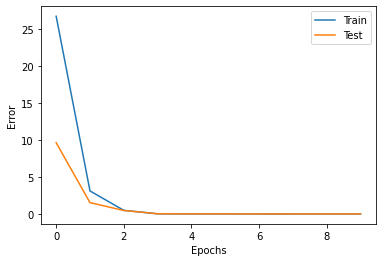

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと